In [2]:
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split


In [3]:
import os
os.environ['KAGGLE_USERNAME']="mqasimali"
os.environ['KAGGLE_KEY']="03318089e106031ba1a9847ff6f1fd25"
!kaggle datasets download sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
brain-tumor-classification-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip /content/brain-tumor-classification-mri

Archive:  /content/brain-tumor-classification-mri.zip
replace Testing/glioma_tumor/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
# Define the path to your dataset
dataset_path = '/content/Training'

image_paths = []
labels = []

for label in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, label)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, filename))
            labels.append(label)

data = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

print(data.head())

print(data['label'].value_counts())

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

                                  image_path     label
0   /content/Training/no_tumor/image(13).jpg  no_tumor
1  /content/Training/no_tumor/image(239).jpg  no_tumor
2  /content/Training/no_tumor/image(268).jpg  no_tumor
3   /content/Training/no_tumor/image(80).jpg  no_tumor
4  /content/Training/no_tumor/image(217).jpg  no_tumor
label
pituitary_tumor     827
glioma_tumor        826
meningioma_tumor    822
no_tumor            395
Name: count, dtype: int64
Training set size: 2296
Testing set size: 574


In [6]:
from tqdm import tqdm
X_train = []
y_train = []

labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


image_size = 150
for i in labels:
    folderPath = os.path.join('/content/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 173.53it/s]


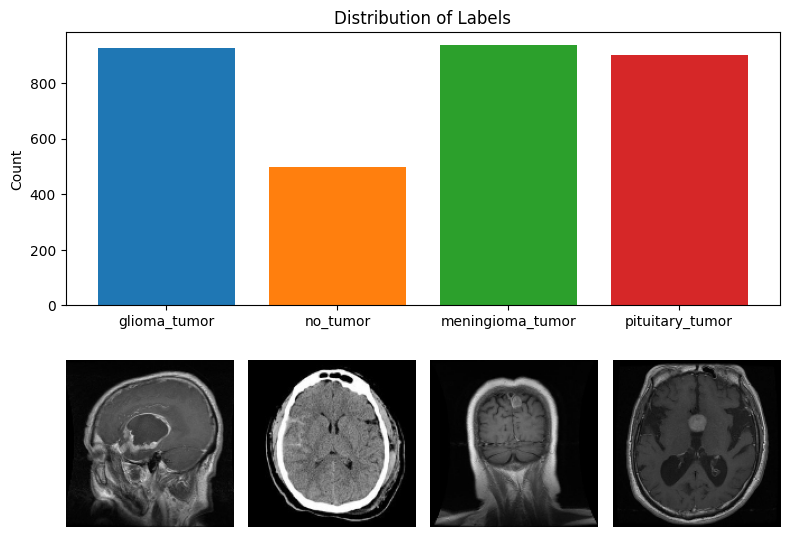

In [7]:
import matplotlib.pyplot as plt

label_counts = {label: np.sum(y_train == label) for label in labels}
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()

In [8]:
image_size = (150, 150)
batch_size = 32
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
import random

def load_images(df, image_size):
    images = []
    labels = []
    for index, row in df.iterrows():
        img = Image.open(row['image_path']).convert('RGB')
        img = img.resize(image_size)
        img_array = np.array(img)
        images.append(img_array)
        labels.append(row['label'])
    return np.array(images), np.array(labels)


def oversample_dataset(X, y, target_count):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_X = []
    augmented_y = []

    for label in np.unique(y, axis=0):
        label_indices = [i for i, l in enumerate(y) if np.array_equal(l, label)]
        X_label = X[label_indices]
        y_label = y[label_indices]
        count = len(label_indices)

        augmented_X.extend(X_label)
        augmented_y.extend(y_label)

        if count < target_count:
            samples_to_generate = target_count - count
            gen = datagen.flow(X_label, y_label, batch_size=1)
            for _ in range(samples_to_generate):
                img, lbl = gen.next()
                augmented_X.append(img[0])
                augmented_y.append(lbl[0])

    return np.array(augmented_X), np.array(augmented_y)

# Load images
X_train, y_train = load_images(train_data, image_size)
X_test, y_test = load_images(test_data, image_size)

X_train = X_train / 255.0
X_test = X_test / 255.0

lb = LabelBinarizer()
y_train_categorical = lb.fit_transform(y_train)
y_test_categorical = lb.transform(y_test)

label_counts = Counter(y_train)
target_count = max(label_counts.values())

X_train, y_train_categorical = oversample_dataset(X_train, y_train_categorical, target_count)
X_test, y_test_categorical = oversample_dataset(X_test, y_test_categorical, target_count)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train_categorical.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Testing labels shape: {y_test_categorical.shape}")


Training data shape: (2684, 150, 150, 3)
Training labels shape: (2684, 4)
Testing data shape: (2684, 150, 150, 3)
Testing labels shape: (2684, 4)


In [9]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(lb.classes_), activation='softmax')
])
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model
history = model.fit(datagen.flow(X_train, y_train_categorical, batch_size=batch_size),
                    validation_data=(X_test, y_test_categorical),
                    epochs=80)


Epoch 1/80
84/84 [==============================] - 37s 363ms/step - loss: 1.3078 - accuracy: 0.3625 - val_loss: 1.1172 - val_accuracy: 0.5235
Epoch 2/80
84/84 [==============================] - 16s 194ms/step - loss: 1.1442 - accuracy: 0.5127 - val_loss: 1.0249 - val_accuracy: 0.5585
Epoch 3/80
84/84 [==============================] - 17s 199ms/step - loss: 1.0326 - accuracy: 0.5570 - val_loss: 0.9227 - val_accuracy: 0.6457
Epoch 4/80
84/84 [==============================] - 16s 191ms/step - loss: 0.9310 - accuracy: 0.6103 - val_loss: 0.8975 - val_accuracy: 0.6103
Epoch 5/80
84/84 [==============================] - 16s 194ms/step - loss: 0.9188 - accuracy: 0.6203 - val_loss: 0.8089 - val_accuracy: 0.6695
Epoch 6/80
84/84 [==============================] - 17s 201ms/step - loss: 0.8747 - accuracy: 0.6345 - val_loss: 0.7511 - val_accuracy: 0.6900
Epoch 7/80
84/84 [==============================] - 16s 185ms/step - loss: 0.8151 - accuracy: 0.6669 - val_loss: 0.7227 - val_accuracy: 0.6889

In [10]:

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test accuracy: {accuracy * 100:.2f}%")

84/84 [==============================] - 1s 11ms/step - loss: 0.3120 - accuracy: 0.8908
Test accuracy: 89.08%


In [11]:
model.save("brain.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
